In [1]:
import torch
import timeit
import pygame
import gymnasium as gym

pygame 2.5.2 (SDL 2.28.2, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from gymnasium.experimental.vector import VectorEnv
from gymnasium.vector.utils import batch_space

## Env

In [3]:
class tenv(VectorEnv):
    def __init__(self,
                 num_envs: int = 2,
                 max_episode_steps = 20):
        super().__init__()
        self.num_envs = num_envs
        self.max_episode_steps = max_episode_steps
        self.state = None
        

    def step(self, action):
        terminated = self.state==action
        reward = torch.zeros((self.num_envs,1))+terminated

        if any(terminated):
            self.state = torch.where(terminated,
                                     torch.randint(10, size=(1,1)).float(),
                                     self.state)
        return self.state, reward, terminated, None, {}

    def reset(self):
        self.state = torch.randint(10,
                                   size=(self.num_envs,1)).float()
        return self.state, {}

In [4]:
num_envs=2
env = tenv(num_envs=num_envs)

In [5]:
env.reset()

(tensor([[2.],
         [1.]]),
 {})

In [6]:
action=torch.randint(10, size=(num_envs,1))
print(action)
step_out=env.step(action)
print(step_out)

tensor([[7],
        [3]])
(tensor([[2.],
        [1.]]), tensor([[0.],
        [0.]]), tensor([[False],
        [False]]), None, {})


#### Env Tensor Testing

In [114]:
state = torch.randint(10, size=(num_envs,1))

In [115]:
dones=state==state

In [116]:
dones

tensor([[True],
        [True]])

In [117]:
dones.sum()

tensor(2)

In [118]:
state[dones] = torch.randint(10, size=(dones.sum(),1))

RuntimeError: shape mismatch: value tensor of shape [2, 1] cannot be broadcast to indexing result of shape [2]

In [143]:
torch.where(done, torch.randint(10, size=(1,1)), state)

tensor([[6],
        [7]])

In [144]:
state

tensor([[6],
        [7]])

In [120]:
state[dones]

tensor([6, 7])

In [113]:
state

tensor([[3, 3],
        [4, 6]])

## Network

In [158]:
import torch.nn as nn
import torch.nn.functional as F

class sim_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1,10)
        self.lin2 = nn.Linear(10,10)
        self.lin3 = nn.Linear(10,1)

    def forward(self, input):
        o1 = self.lin1(input)
        o2 = self.lin2(o1)
        return self.lin3(o2)

model = sim_net()

In [159]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

num_envs=100
env = tenv(num_envs=num_envs)

In [160]:
obs, log = env.reset()
loss_arr=[]

(0.0, 100.0)

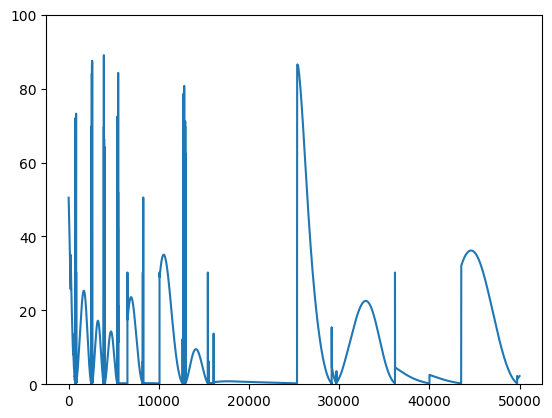

In [170]:
for _ in range(5000):
    action=model(obs)*10
    raction=torch.round(action)
    #print("action", action)
    #print("raction", raction)
    obs, reward, terminated, _, info =env.step(raction)
    #print(obs, reward, terminated, _, info, sep="\n")
    
    loss = loss_fn(action, obs)
    loss_arr.append(loss.detach().cpu())
    #print("loss:", loss)
    loss.backward()
    optimizer.step()
    
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.ylim(0,100)